
**LSTM Model - APPLE Stock Prediction**



In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn import metrics

In [ ]:
# Set the random seed for reproducibility
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [ ]:
# Read APPL.csv contains open, high, low, close, Adj close, Volume of Apple stock with twitter polarity scores and twitter volume
df = pd.read_csv('/content/AAPL.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

# Drop null values
df.dropna(inplace=True)
df.tail()

<ipython-input-5-0d8084405f67>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('/content/AAPL.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)


,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2019-08-26,51.47,51.80,51.26,51.62,51.12,104174400,0.072340,888.0
2019-08-27,51.97,52.14,50.88,51.04,50.54,103493200,0.117541,962.0
2019-08-28,51.03,51.43,50.83,51.38,50.88,63755200,0.061477,895.0
2019-08-29,52.13,52.33,51.67,52.25,51.74,83962000,0.056460,1083.0
2019-08-30,52.54,52.61,51.80,52.19,51.67,84573600,0.106096,1005.0


In [ ]:
# Dataframe with Adj close, ts_polarity, twitter_volume of APPL
df = df[["Adj Close", "ts_polarity", "twitter_volume"]]
df.head()

,Adj Close,ts_polarity,twitter_volume
Date,,,
2016-01-04,24.44,0.070389,1133.0
2016-01-05,23.83,0.133635,1430.0
2016-01-06,23.36,0.072042,1949.0
2016-01-07,22.38,0.074369,2289.0
2016-01-08,22.50,0.051595,2235.0


In [ ]:
# pct change based on Adj close value
df["Pct_change"] = df["Adj Close"].pct_change()

# Drop null values
df.dropna(inplace = True)
df.head()

,Adj Close,ts_polarity,twitter_volume,Pct_change
Date,,,,
2016-01-05,23.83,0.133635,1430.0,-0.024959
2016-01-06,23.36,0.072042,1949.0,-0.019723
2016-01-07,22.38,0.074369,2289.0,-0.041952
2016-01-08,22.50,0.051595,2235.0,0.005362
2016-01-11,22.86,0.019443,1222.0,0.016000


**Creating the Features X and Target y Data**

The first step towards preparing the data was to create the input features X and the target vector y. We used the window_data() function to create these vectors.
This function chunks the data up with a rolling window of Xt - window to predict Xt.

The function returns two numpy arrays:

X: The input features vectors.

y: The target vector.

The function has the following parameters:

df: The original DataFrame with the time series data.

window: The window size in days of previous closing prices that will be used for the prediction.

feature_col_number: The column number from the original DataFrame where the features are located.

target_col_number: The column number from the original DataFrame where the target is located.

In [ ]:
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_polarity", "X_volume" and y
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    for i in range(len(df) - window):

        # Get close, ts_polarity, tw_vol, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]

        # Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)

    return np.hstack((X_close,X_polarity,X_volume)), np.array(y).reshape(-1, 1)

In [ ]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [ ]:
# Use 70% of the data for training and the remaineder for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

**Scaling Data with MinMaxScaler**

 MinMaxScaler from sklearn to scale all values between 0 and 1. Scale both features and target sets.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

**Reshape Features Data for the LSTM Model**

The LSTM API from Keras needs to receive the features data as a vertical vector, so that we need to reshape the X data in the form reshape((X_train.shape[0], X_train.shape[1], 1)).

Both sets, training, and testing are reshaped.

In [ ]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

**Build and Train the LSTM RNN**

Defined the model architecture
Compiled the model
Fit the model to the training data
Importing the Keras Modules
The LSTM RNN model in Keras uses the Sequential model, the LSTM layer and a Dropout layer.

Dropout: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

**Defining the LSTM RNN Model Structure**

To create an LSTM RNN model, we added LSTM layers. The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer. The input_shape is the number of time steps and the number of indicators

After each LSTM layer, we add a Dropout layer to prevent overfitting. The parameter passed to the Dropout layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of 0.2, it means that on each epoch we will randomly drop 20% of the units.

The number of units in each LSTM layers, is equal to three times the size of the time window, we are taking three previous closing prices to predict the next closing price.

In [ ]:
# Build the LSTM model.

# Define the LSTM RNN model.
model = Sequential()

number_units = 9
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )

model.add(Dropout(dropout_fraction))

# Layer 2
# The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer.
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compiling the LSTM RNN Model**


Compiled the model, using the adam optimizer, as loss function, will use mean_square_error since the value to predict is continuous.

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Summarize the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 9, 9)                │             396 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 9, 9)                │             684 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 9)                   │             684 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,774 (6.93 KB)

 Trainable params: 1,774 (6.93 KB)

 Non-trainable params: 0 (0.00 B)

**Training the Model**

Once the model is defined, we train (fit) the model using 10 epochs. Since we are working with time-series data, it's important to set shuffle=False since it's necessary to keep the sequential order of the data.

We can experiment with the batch_size parameter; however, smaller batch size is recommended; we used batch_size=5.

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=5, verbose=1)

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0095
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1255
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1177
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0923
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0435
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0134
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0046
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0082
Epoch 9/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0053
Epoch 10/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0051


Model Performance

We will evaluate the model using the test data.

We will:

Evaluate the model using the X_test and y_test data.
Use the X_test data to make predictions
Create a DataFrame of Real (y_test) vs predicted values.
Plot the Real vs predicted values as a line chart

In [ ]:
# Evaluate the model for loss
model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152  


0.018019165843725204

In [ ]:
# Make some predictions
predicted = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [ ]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.13423549251024025
R-squared : 0.6759893083089995


In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
Date,,
2018-07-27,46.39,51.433643
2018-07-30,46.13,50.235569
2018-07-31,46.22,50.802872
2018-08-01,48.95,49.901619
2018-08-02,50.38,50.664032


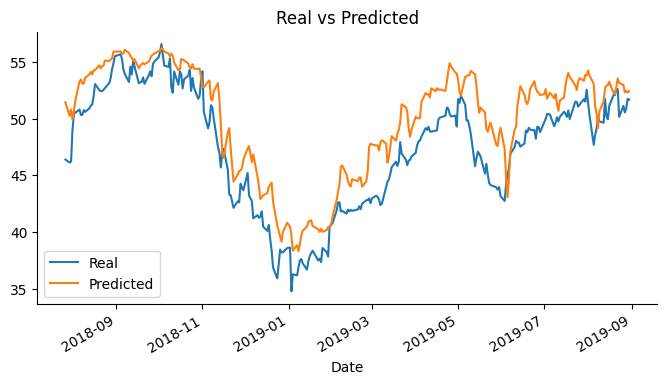

In [ ]:
from matplotlib import pyplot as plt

# Plotting the real and predicted stock values
stocks['Real'].plot(kind='line', figsize=(8, 4), label='Real')  # Add label for legend
stocks['Predicted'].plot(kind='line', figsize=(8, 4), title='Real vs Predicted', label='Predicted')  # Add label for legend

# Hide the top and right spines of the plot
plt.gca().spines[['top', 'right']].set_visible(False)

# Add legend to the plot
plt.legend()

# Show the plot
plt.show()
